### UNet, Encode-decode 모델, VGG16모델을 활용한 용종 이미지 segmentation

회고: UNet을 통해 이미지 검출을 해보았는데, 생각보다 정확도가 굉장히 높아서 신기했음. UNnet만 잘 활용해도 마스킹을 잘 할 수 있다면 원하는 질환들을 잘 찾을 수 있을거라는 생각이 들었다. 생각보다 인코더-디코더 모델, preTrained VGG16모델이 세그멘테이션에는 조금 부족했던것 같은데, 아마 하이퍼파라미터를 더 잘 셋팅해주면 더 좋은 결과가 나오지 않을지 싶다.

어려웠던점 - 데이터 증강시, 데이터셋에 넣는 방법이 아직 익숙치않다. tf.keras.dataset을 더 자주 접해보고, 문서도 읽어보아야겠다.
기본적인 방법에서 살짝만 더 추가한 경우가 가장 높은것이 조금 의외지만, 그만큼 모델을 잘 활용한다는 것은 대단한 모델보다 적합한 모델을 사용하는것이 중요한 것 같다.

# 목차

1 데이터 로드 및 Visualization

2 Data pipeline and Preprocessing

*   2-1. 하이퍼 파라미터 설정

3 Build the model

*   3-1. 모델 셋팅 (E-D Model)
*   3-2. 모델 셋팅 (UNet)

4 Train model

*   4-1. E-D 모델 - 그래프 및 mean_iou값
    - mean_iou: 0.4785570573997318
*   4-2. UNet - 그래프 및 mean_iou값
    - mean_iou: 0.9410611505577927

5 프로젝트: U-Net 성능 개선해 보기


# 1 데이터 로드 및 Visualization

In [ ]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping

2.6.0


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATASET_PATH = '/content/drive/MyDrive/data/main_quest/'

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [5]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [6]:
len(x_train_filenames), len(y_train_filenames)

(300, 300)

In [7]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [8]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


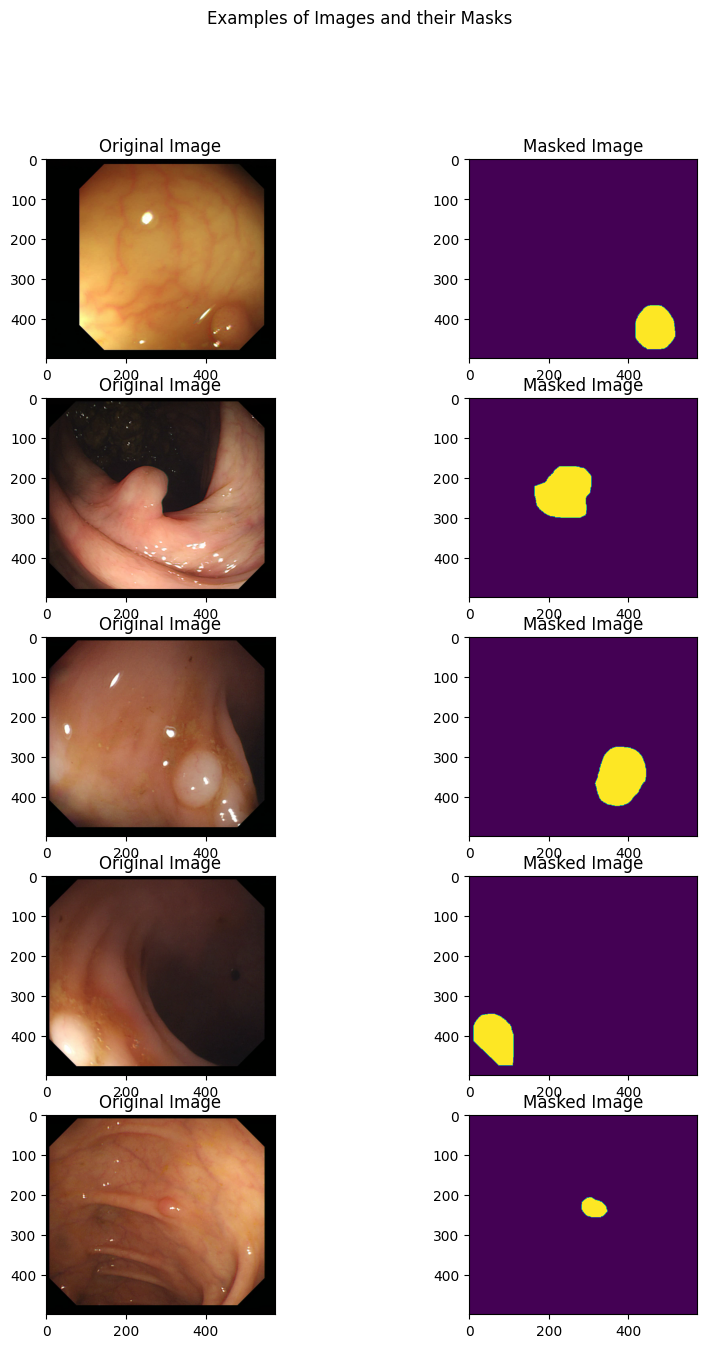

In [9]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")

plt.suptitle("Examples of Images and their Masks")
plt.show()

# 2 Data pipeline and Preprocessing

## 2-1. 하이퍼 파라미터 설정

In [10]:
# Set hyperparameters

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 10

In [11]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

In [12]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

In [13]:
def flip_img(horizontal_flip, tr_img, label_img):

    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))

    return tr_img, label_img

In [14]:
# 이미지 증강
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically

    if resize is not None:
        # Resize both images
        img = tf.image.resize(img, resize)
        label_img = tf.image.resize(label_img, resize)

    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)

    # 이미지 증강하기 - flip_img
    img, label_img = flip_img(horizontal_flip, img, label_img)

    # 이미지 증강하기 - shift_img
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)

    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale

    return img, label_img

In [15]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):

    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [ ]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터

train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

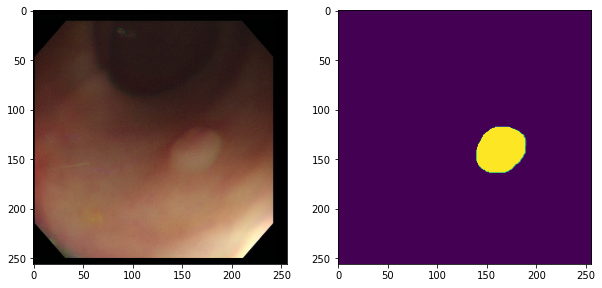

In [ ]:
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

# 3 Build the model

## 3-1. 모델 셋팅 (E-D Model)

In [ ]:
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

In [ ]:
# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print(bottleneck.shape)   # (batch_size, 16, 16, 512) 이 나오는지 확인

In [ ]:
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

In [ ]:
# decoder 제대로 만들어졌는지 확인

predictions = decoder(bottleneck)
print(predictions.shape)    # (batch_size, 256, 256, 1) 이 나오는지 확인

In [ ]:
ed_model = tf.keras.Sequential()

ed_model.add(encoder)
ed_model.add(decoder)

## 3-2. 모델 셋팅 (UNet)

In [ ]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [ ]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [ ]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

In [ ]:
unet_model = UNet()

In [ ]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [ ]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [ ]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

In [ ]:
# 위에서 구성한 두가지 모델 중에서 하나를 선택해 주세요.
# 여기서 선택을 바꾸어 다른 모델의 학습도 진행해 볼 수 있습니다.

#print('select the Encoder-Decoder model')
#model = ed_model
#checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

print('select the U-Net model')
model = unet_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/unet_model')

select the U-Net model


In [ ]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [ ]:
model.summary()

Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block (EncoderBlock) multiple                  76416     
_________________________________________________________________
encoder_block_1 (EncoderBloc multiple                  444288    
_________________________________________________________________
encoder_block_2 (EncoderBloc multiple                  1773312   
_________________________________________________________________
encoder_block_3 (EncoderBloc multiple                  7085568   
_________________________________________________________________
conv_block_4 (ConvBlock)     multiple                  28326912  
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  18882048  
_________________________________________________________________
decoder_block_1 (DecoderBloc multiple                  354278

In [ ]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [ ]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3,
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

# 4 Train model

In [ ]:
print('select the Encoder-Decoder model')
model = ed_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

select the Encoder-Decoder model


In [ ]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

cos_decay = tf.keras.experimental.CosineDecay(1e-3,
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(
    monitor='val_loss',   # 모니터링할 값 ('val_loss', 'val_accuracy' 등)
    patience=4,           # 성능이 향상되지 않는 epoch 수 (조기 종료를 위한 조건)
    restore_best_weights=True  # True로 설정 시, 학습 중 가장 성능이 좋았던 모델의 가중치를 복원
)

In [ ]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

model.summary()

(8, 256, 256, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (8, 16, 16, 512)          4693056   
_________________________________________________________________
decoder (Sequential)         (8, 256, 256, 1)          2354913   
Total params: 7,047,969
Trainable params: 7,042,209
Non-trainable params: 5,760
_________________________________________________________________


In [ ]:
history = model.fit(train_dataset,
                    epochs=50,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback, early_stopping_callback]
                    )

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 12s 209ms/step - loss: 1.2693 - dice_loss: 0.7884 - val_loss: 2.9990 - val_dice_loss: 0.8731
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 7s 196ms/step - loss: 1.0279 - dice_loss: 0.7334 - val_loss: 1.9179 - val_dice_loss: 0.8398
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 7s 198ms/step - loss: 0.9368 - dice_loss: 0.6770 - val_loss: 2.4879 - val_dice_loss: 0.8722
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 7s 199ms/step - loss: 0.8490 - dice_loss: 0.6219 - val_loss: 1.0754 - val_di

## 4-1. E-D 모델 학습 - 그래프, mean_iou 0.4785570573997318

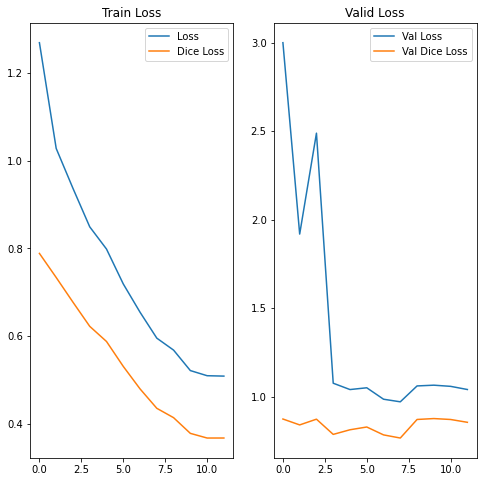

In [ ]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(12)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [ ]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.4785570573997318


In [ ]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

In [ ]:
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 36s 823ms/step - loss: 1.0213 - dice_loss: 0.7234 - val_loss: 28695.2324 - val_dice_loss: 1.0000
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 26s 817ms/step - loss: 0.9149 - dice_loss: 0.7051 - val_loss: 35.9808 - val_dice_loss: 0.9797
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 26s 833ms/step - loss: 0.9032 - dice_loss: 0.6990 - val_loss: 1.0847 - val_dice_loss: 0.8126
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 27s 849ms/step - loss: 0.8929 - dice_loss: 0.6889 - val_loss: 11.5364

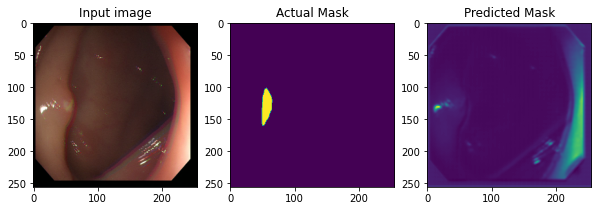

In [ ]:
# print sample image after training
print_images()

## 4-2. UNet 모델 학습 - 그래프, mean_iou 0.9410611505577927




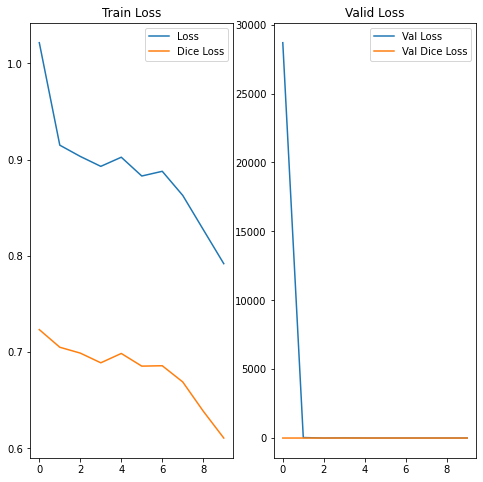

In [ ]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [ ]:
# 원하는 모델을 불러올 수 있도록 적절히 주석을 처리하세요
# checkpoint_dir = os.path.join(DATASET_PATH, 'ed_ckpt/ed_model')
checkpoint_dir = os.path.join(DATASET_PATH, 'unet_ckpt/unet_model')

# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

In [ ]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [ ]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.9410611505577927


In [ ]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

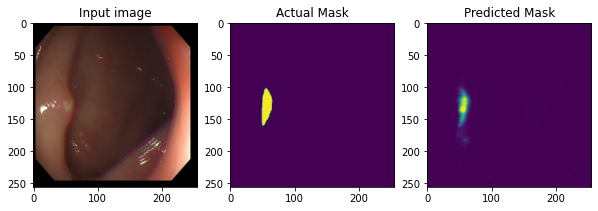

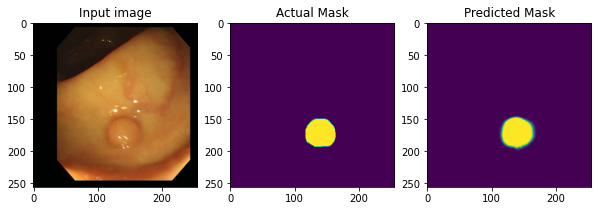

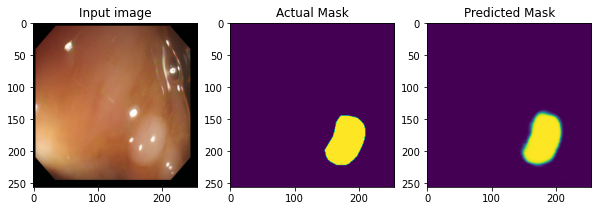

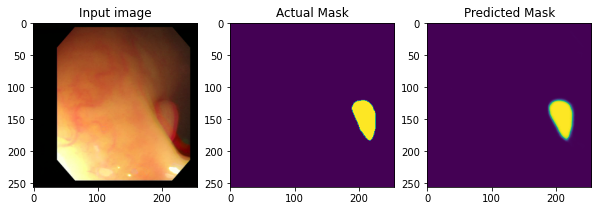

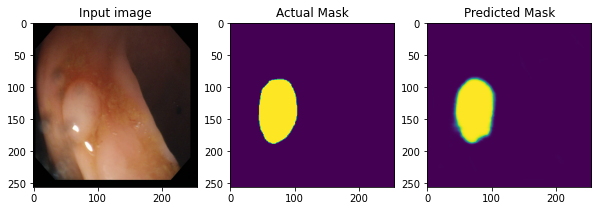

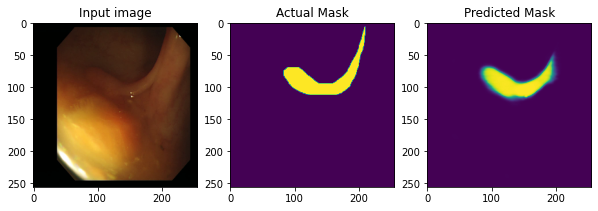

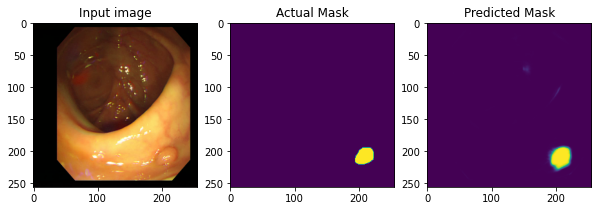

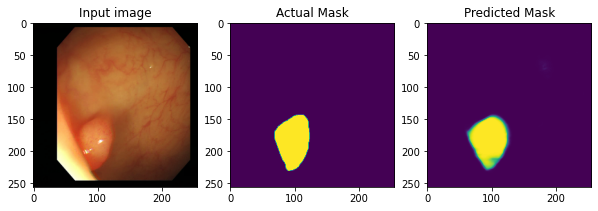

In [ ]:
print_images()

# 5 프로젝트: U-Net 성능 개선해 보기

## 5-1. vgg16UNet 사용한 성능 개선

In [18]:
import tensorflow
import sklearn
import numpy

print(tensorflow.__version__)
print(sklearn.__version__)
print(numpy.__version__)

2.17.0
1.3.2
1.26.4


In [19]:
vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
layer_outputs = [layer.output for layer in vgg16.layers]
layer_outputs

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


[<KerasTensor shape=(None, 256, 256, 3), dtype=float32, sparse=None, name=keras_tensor>,
 <KerasTensor shape=(None, 256, 256, 64), dtype=float32, sparse=False, name=keras_tensor_1>,
 <KerasTensor shape=(None, 256, 256, 64), dtype=float32, sparse=False, name=keras_tensor_2>,
 <KerasTensor shape=(None, 128, 128, 64), dtype=float32, sparse=False, name=keras_tensor_3>,
 <KerasTensor shape=(None, 128, 128, 128), dtype=float32, sparse=False, name=keras_tensor_4>,
 <KerasTensor shape=(None, 128, 128, 128), dtype=float32, sparse=False, name=keras_tensor_5>,
 <KerasTensor shape=(None, 64, 64, 128), dtype=float32, sparse=False, name=keras_tensor_6>,
 <KerasTensor shape=(None, 64, 64, 256), dtype=float32, sparse=False, name=keras_tensor_7>,
 <KerasTensor shape=(None, 64, 64, 256), dtype=float32, sparse=False, name=keras_tensor_8>,
 <KerasTensor shape=(None, 64, 64, 256), dtype=float32, sparse=False, name=keras_tensor_9>,
 <KerasTensor shape=(None, 32, 32, 256), dtype=float32, sparse=False, name=k

In [20]:
class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input,
                                      outputs=[layer_outputs[2],
                                               layer_outputs[5],
                                               layer_outputs[9],
                                               layer_outputs[13],
                                               layer_outputs[17]])


        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):

        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

In [ ]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

cos_decay = tf.keras.experimental.CosineDecay(1e-3,
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

In [ ]:
class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input,
                                      outputs=[layer_outputs[2],
                                               layer_outputs[5],
                                               layer_outputs[9],
                                               layer_outputs[13],
                                               layer_outputs[17]])


        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):

        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

In [ ]:
model = Vgg16UNet()

# 모델 컴파일
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 콜백 설정
# checkpoint = ModelCheckpoint('vgg16_unet.keras', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# 모델 학습
history = model.fit(train_dataset,
                    steps_per_epoch=num_train_examples // batch_size,
                    epochs=50,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples // batch_size,
                    callbacks=[cp_callback, lr_callback, early_stopping])


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 29s 571ms/step - loss: 0.2709 - accuracy: 0.9209 - val_loss: 6.3230 - val_accuracy: 0.7052
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 18s 564ms/step - loss: 0.1816 - accuracy: 0.9475 - val_loss: 0.4764 - val_accuracy: 0.8216
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 19s 572ms/step - loss: 0.1693 - accuracy: 0.9475 - val_loss: 0.2684 - val_accuracy: 0.9459
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 19s 580ms/step - loss: 0.1630 - accuracy: 0.9475 - val_loss: 0.2358 - val_accura

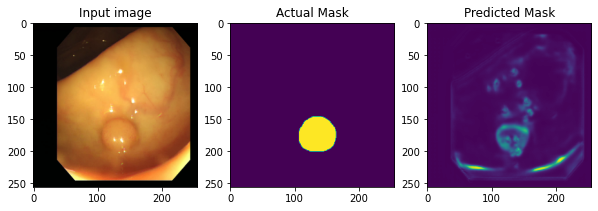

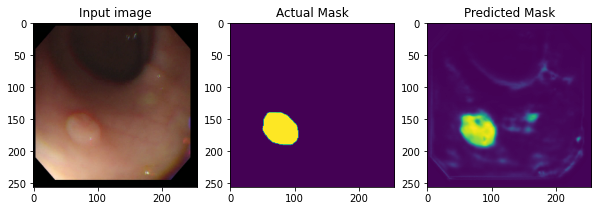

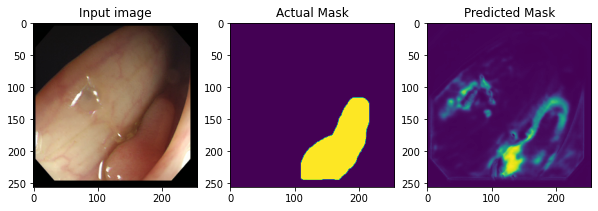

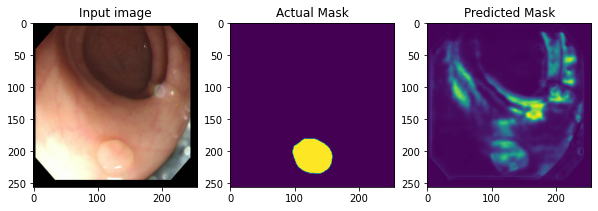

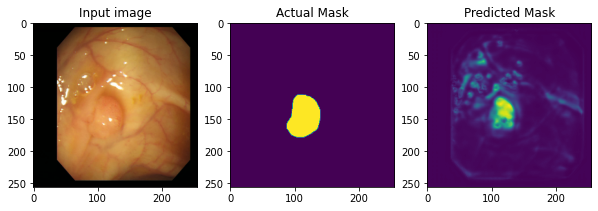

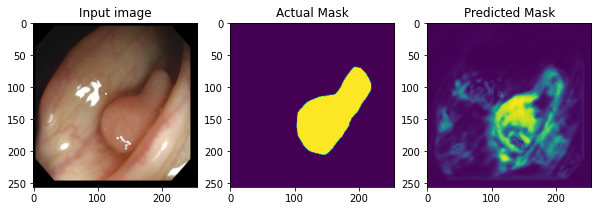

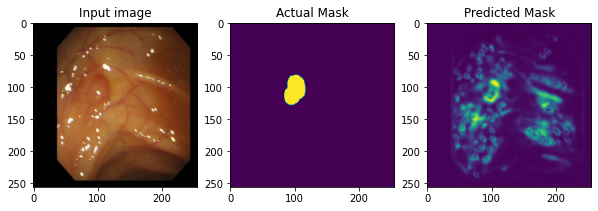

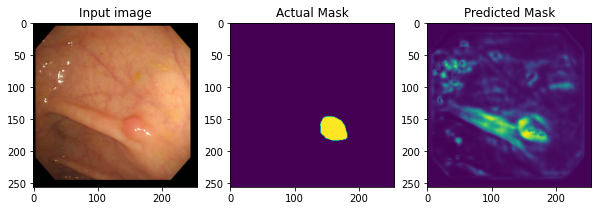

In [ ]:
# print sample image after training
print_images()

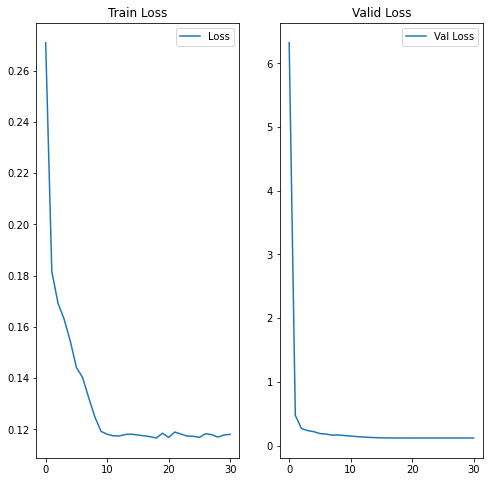

In [ ]:
# dice_loss = history.history['dice_loss']
loss = history.history['loss']
# val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(31)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
# plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
# plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [ ]:

# 콜백 설정
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='dice_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

early_stopping = EarlyStopping(monitor='dice_loss', patience=3)

# 모델 학습
history = model.fit(train_dataset,
                    steps_per_epoch=num_train_examples // batch_size,
                    epochs=10,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples // batch_size,
                    callbacks=[cp_callback, lr_callback, early_stopping])

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 27s 575ms/step - loss: 0.9055 - dice_loss: 0.6471 - val_loss: 2.6871 - val_dice_loss: 0.9999

Epoch 00001: dice_loss improved from inf to 0.64712, saving model to /aiffel/aiffel/medical/train_ckpt/vgg16_model
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 18s 569ms/step - loss: 0.7163 - dice_loss: 0.5409 - val_loss: 1.0219 - val_dice_loss: 0.7946

Epoch 00002: dice_loss improved from 0.64712 to 0.54090, saving model to /aiffel/aiffel/medical/train_ckpt/vgg16_model
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 19s 575ms/step - loss: 0.6518 - dice_loss: 0.4912 - val_loss: 2.2483 - val_dice_loss: 0.8808

E

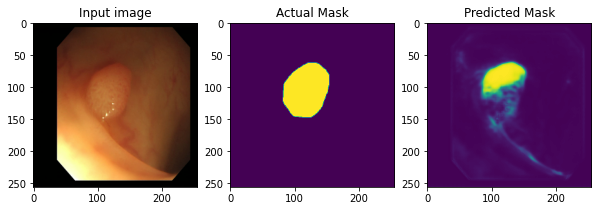

In [ ]:
# print sample image after training
print_images()

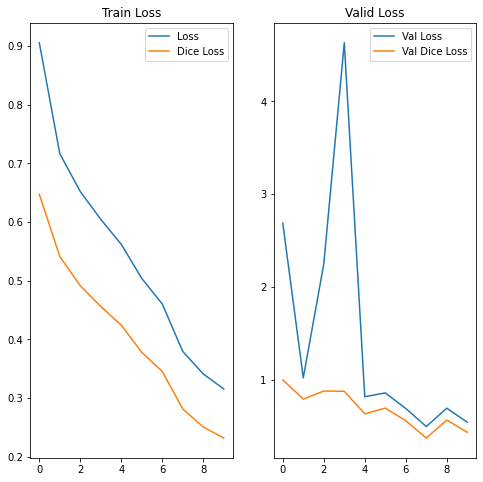

In [ ]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()


## 5-1-1 VGG16 UNET 그래프, mean_iou: 0.6434274854103221
10에포크 돌렸을때 - 0.6434274854103221

In [ ]:

mean = []
for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.6434274854103221


## 5-1-2 30회 추가학습, 16회 Early Stopping - mean_iou: 0.8013118133272221

30회 추가 학습시키고, EarlyStoping 16회 진행 - mean_iou: 0.8013118133272221


In [ ]:
# 콜백 설정
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='dice_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

early_stopping = EarlyStopping(monitor='dice_loss', patience=3)

# 모델 학습
history = model.fit(train_dataset,
                    steps_per_epoch=num_train_examples // batch_size,
                    epochs=30,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples // batch_size,
                    callbacks=[cp_callback, lr_callback, early_stopping])

Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 19s 583ms/step - loss: 0.4276 - dice_loss: 0.3196 - val_loss: 1.8318 - val_dice_loss: 0.7188

Epoch 00001: dice_loss improved from inf to 0.31959, saving model to /aiffel/aiffel/medical/train_ckpt/vgg16_model
Epoch 2/30

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 19s 586ms/step - loss: 0.4503 - dice_loss: 0.3392 - val_loss: 0.5679 - val_dice_loss: 0.4330

Epoch 00002: dice_loss did not improve from 0.31959
Epoch 3/30

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 19s 593ms/step - loss: 0.4107 - dice_loss: 0.3086 - val_loss: 0.6465 - val_dice_loss: 0.5045

Epoch 00003: dice_loss improved from 0.31959 to 0.30861, saving mode

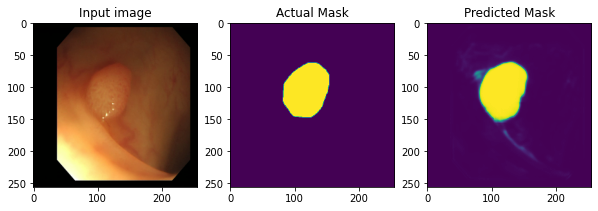

In [ ]:
# print sample image after training
print_images()

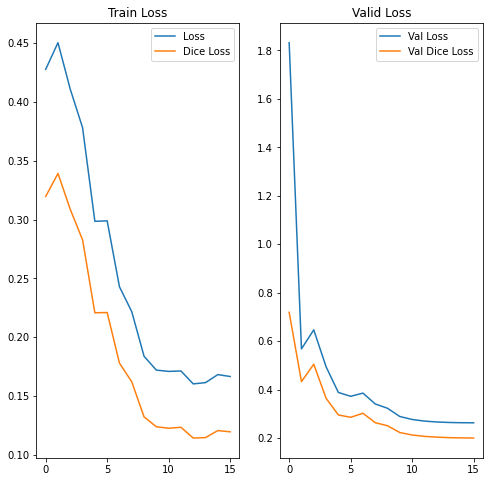

In [ ]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(16)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()


In [ ]:

mean = []
for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.8013118133272221


## 5-2. 데이터 증강적용 및 가장 높았던 UNET에서 최대 에포크로 진행

In [ ]:
def flip_img(horizontal_flip, tr_img, label_img):

    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))

    return tr_img, label_img

def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

def rotate_img(img, label_img, max_angle=20):
    """이미지를 랜덤 각도로 회전합니다."""
    angle = tf.random.uniform([], -max_angle, max_angle)
    img = tfa.image.rotate(img, angle * tf.constant(np.pi / 180, tf.float32))
    label_img = tfa.image.rotate(label_img, angle * tf.constant(np.pi / 180, tf.float32))
    return img, label_img

def zoom_img(img, label_img, zoom_range=(0.8, 1.2)):
    """이미지를 랜덤하게 확대 또는 축소합니다."""
    scale = tf.random.uniform([], zoom_range[0], zoom_range[1])
    img = tf.image.resize(img, [int(image_size * scale), int(image_size * scale)])
    label_img = tf.image.resize(label_img, [int(image_size * scale), int(image_size * scale)])

    # 중앙 자르기 또는 패딩하여 원래 크기로 만듭니다.
    img = tf.image.resize_with_crop_or_pad(img, image_size, image_size)
    label_img = tf.image.resize_with_crop_or_pad(label_img, image_size, image_size)

    return img, label_img

def adjust_saturation(img, label_img, lower=0.7, upper=1.3):
    """이미지의 채도를 조정합니다."""
    img = tf.image.random_saturation(img, lower, upper)
    return img, label_img

def adjust_contrast(img, label_img, lower=0.8, upper=1.2):
    """이미지의 대비를 조정합니다."""
    img = tf.image.random_contrast(img, lower, upper)
    return img, label_img

# 이미지 증강
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05,  # Randomly translate the image vertically
             max_rotation=20,  # Max rotation angle
             zoom_range=(0.8, 1.2),  # Random zoom range
             saturation_range=(0.7, 1.3),  # Random saturation adjustment
             contrast_range=(0.8, 1.2)):  # Random contrast adjustment

    if resize is not None:
        # Resize both images
        img = tf.image.resize(img, resize)
        label_img = tf.image.resize(label_img, resize)

    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)

    # 이미지 증강하기 - flip_img
    img, label_img = flip_img(horizontal_flip, img, label_img)

    # 이미지 증강하기 - shift_img
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)

    # 이미지 증강하기 - rotate_img
    img, label_img = rotate_img(img, label_img, max_angle=max_rotation)

    # 이미지 증강하기 - zoom_img
    img, label_img = zoom_img(img, label_img, zoom_range=zoom_range)

    # 이미지 증강하기 - adjust_saturation
    img, label_img = adjust_saturation(img, label_img, lower=saturation_range[0], upper=saturation_range[1])

    # 이미지 증강하기 - adjust_contrast
    img, label_img = adjust_contrast(img, label_img, lower=contrast_range[0], upper=contrast_range[1])

    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale

    return img, label_img

In [ ]:
def duplicate_and_augment(img, label_img, augment_fn):
    """이미지를 복사하여 원본과 증강된 버전을 모두 데이터셋에 추가합니다."""
    augmented_img, augmented_label_img = augment_fn(img, label_img)
    # 원본 이미지와 증강된 이미지를 함께 반환
    return tf.stack([img, augmented_img]), tf.stack([label_img, augmented_label_img])

def get_enhanced_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):

    num_x = len(filenames)
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:
        dataset = dataset.map(lambda img, label: duplicate_and_augment(img, label, preproc_fn),
                              num_parallel_calls=threads)
        dataset = dataset.unbatch()  # 스택된 이미지를 분리하여 배치로 만듭니다.
        dataset = dataset.shuffle(num_x * 20)  # 원본과 증강된 이미지를 모두 섞습니다.

    dataset = dataset.batch(batch_size)
    return dataset

# 수정된 데이터셋 생성을 사용하여 데이터셋을 준비합니다.
train_dataset = get_enhanced_dataset(x_train_filenames, y_train_filenames)
train_dataset = train_dataset.repeat()

test_dataset = get_baseline_dataset(x_test_filenames, y_test_filenames, is_train=False)


In [ ]:
early_stopping = EarlyStopping(monitor='dice_loss', patience=5)

In [ ]:
history = model.fit(train_dataset,
                    epochs=50,
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
60/60 [==============================] - 36s 464ms/step - loss: 0.9928 - dice_loss: 0.7296 - val_loss: 1679.6763 - val_dice_loss: 0.9144
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
60/60 [==============================] - 28s 465ms/step - loss: 0.9170 - dice_loss: 0.7170 - val_loss: 2.0665 - val_dice_loss: 0.8753
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
60/60 [==============================] - 31s 471ms/step - loss: 0.9114 - dice_loss: 0.7161 - val_loss: 1.0959 - val_dice_loss: 0.8657
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
60/60 [==============================] - 29s 475ms/step - loss: 0.8993 - dice_loss: 0.6964 - val_loss: 2.1628 - 

In [ ]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.9331208601821711


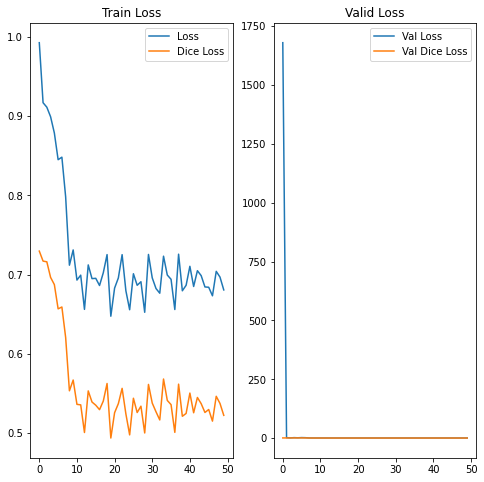

mean_iou: 0.9331208601821711


In [ ]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

## 5-3. VERTICAL 증강만 추가 - 그래프, mean_iou: 0.9458690293906914


In [ ]:
def hflip_img(horizontal_flip, tr_img, label_img):

    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))

    return tr_img, label_img

    def vflip_img(vertical_flip, tr_img, label_img):

    if vertical_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_up_down(tr_img), tf.image.flip_up_down(label_img)),
                                lambda: (tr_img, label_img))

    return tr_img, label_img

    # 이미지 증강
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             vertical_flip=True,  # Random up down flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically

    if resize is not None:
        # Resize both images
        img = tf.image.resize(img, resize)
        label_img = tf.image.resize(label_img, resize)

    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)

    # 이미지 증강 - flip (horizontal)
    img, label_img = hflip_img(horizontal_flip, img, label_img)

    # 이미지 증강 - flip (vertical) 추가
    img, label_img = vflip_img(vertical_flip, img, label_img)

    # 이미지 증강 - shift_img
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)

    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale

    return img, label_img

In [ ]:
history = model.fit(train_dataset,
                    epochs=max_epochs, # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
60/60 [==============================] - 36s 466ms/step - loss: 1.0388 - dice_loss: 0.7335 - val_loss: 2.0091 - val_dice_loss: 0.9151
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
60/60 [==============================] - 29s 464ms/step - loss: 0.9271 - dice_loss: 0.7127 - val_loss: 3.3059 - val_dice_loss: 0.9998
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
60/60 [==============================] - 30s 474ms/step - loss: 0.9215 - dice_loss: 0.7141 - val_loss: 1.0023 - val_dice_loss: 0.8110
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
60/60 [==============================] - 30s 473ms/step - loss: 0.9071 - dice_loss: 0.7067 - val_loss: 0.9536 - val

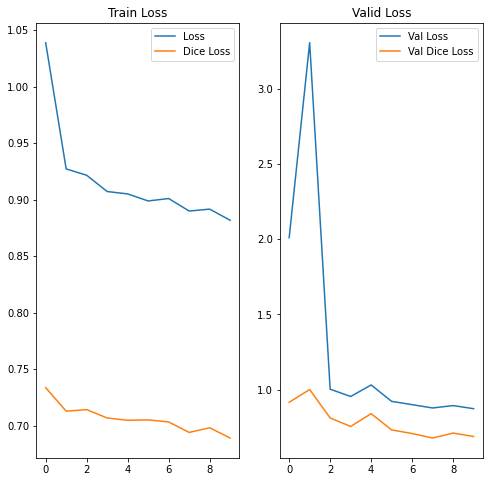

In [ ]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [ ]:
# 원하는 모델을 불러올 수 있도록 적절히 주석을 처리하세요
# checkpoint_dir = os.path.join(DATASET_PATH, 'ed_ckpt/ed_model')
checkpoint_dir = os.path.join(DATASET_PATH, 'unet_ckpt/unet_model')

# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

In [ ]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.9458690293906914
